In [73]:
import torch
import torch.nn.functional as F
import random
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)
torch.manual_seed(42);

words = open('names.txt', 'r').read().splitlines()
# build mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi, itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [74]:
def build_dataset(words):
    global ctx_len
    ctx_len = 3  # context lenght: we use 3 previous character to predict next char
    X, Y = [], []    
    for w in words:
        # print('next word:', w)
        ctx = [0] * ctx_len
        for ch in w + '.':
            ix = stoi[ch] # get int version of next char, this is target
            X.append(ctx) # list of 3 ints, each char in ctx
            Y.append(ix) # next char as int
            # print(f"{''.join(list(map(lambda i: itos[i], ctx )))} ===> {itos[ix]}")
            ctx = ctx[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y


class BatchLoader:    
    def __init__(self, x, y, bs): self.x, self.y, self.bs = x, y, bs        
    def __call__(self):
        '''
        random batch used to estimate grad
        if batch size low -> high variance in grad direction
        '''
        batch_idx = torch.randint(0, self.x.shape[0], (self.bs,)) 
        return self.x[batch_idx], self.y[batch_idx]
class Linear:    
    def __init__(self, inp_dims, out_dims, bias=True):
        self.weight = torch.randn((inp_dims, out_dims)) / inp_dims**.5
        self.bias = torch.zeros(out_dims) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    
    def parameters(self): return [self.weight] + ([] if self.bias is None else [self.bias])

    
class BatchNorm1d:    
    def __init__(self, dims, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # bn params
        self.gamma = torch.ones(dims)
        self.beta = torch.zeros(dims)
        # buffers
        self.running_mean = torch.zeros(dims)
        self.running_var = torch.ones(dims)
        
        
    def __call__(self, x):
        ''' IMPO: this bn version requires x to be 2d'''
        if self.training: # use batch stats
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else: # use running stats
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self): return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self): return []

In [75]:
# global params
batch_size = 32
max_steps = 200000

random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

xtrain, ytrain = build_dataset(words[:n1])
xvalid, yvalid = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

print(xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape, xtest.shape, ytest.shape)

bl = BatchLoader(xtrain, ytrain, 32)
for x,y in zip(xtrain[:20], ytrain[:20]): print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

torch.Size([182625, 3]) torch.Size([182625]) torch.Size([22655, 3]) torch.Size([22655]) torch.Size([22866, 3]) torch.Size([22866])
... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [76]:
class LearnerBN:
    def __init__(self, batch_loader, gain, lr=.1, ctx_len=3, emb_size=10, hidden_shape=200):
        self.batch_loader, self.lr, self.gain = batch_loader, lr, gain        
        self.ctx_len, self.emb_size, self.hidden_shape = ctx_len, emb_size, hidden_shape
        self.vocab_len = 27
        
        self.C = torch.randn(self.vocab_len, self.emb_size)
        self.layers = [
            Linear(self.ctx_len*self.emb_size, self.hidden_shape),
            BatchNorm1d(self.hidden_shape), Tanh(),            
            Linear(self.hidden_shape, self.vocab_len)
        ]

        with torch.no_grad():
            self.layers[-1].weight *= .1 # make last layer logits dist uniform
#             self.layers[-1].gamma *= .1 # if last layer is BatchNorm1d
            for layer in self.layers: 
                if isinstance(layer, Linear): layer.weight *= self.gain

        self.parameters = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters: p.requires_grad = True

            
    def update_lr(self): self.lr = self.lr if self.i < 100000 else .01
    def plot_loss(self): plt.plot(self.iter, self.losses)
    def count_params(self): return self.C.nelement() + sum(p.nelement() for p in self.parameters)
                
    def fit(self, steps):   
        for layer in self.layers: layer.training = True

        self.losses, self.iter = [], []
        for self.i in range(steps+1):

            xb, yb = self.batch_loader()
            emb = self.C[xb] 
            x = emb.view(emb.shape[0], -1)
            for layer in self.layers: x = layer(x)
            loss = F.cross_entropy(x, yb)
            self.losses.append(loss.item()) 
            self.iter.append(self.i)

            for p in self.parameters: p.grad = None
            loss.backward()
            self.update_lr()
            for p in self.parameters: p.data += - self.lr * p.grad   
            if self.i % 50000 == 0: print(f'{self.i}/{steps} loss: {loss.item()}')
    
    @torch.no_grad()
    def evaluate_split_loss(self, xb, yb):
        for layer in self.layers: layer.training = False
        emb = self.C[xb] 
        x = emb.view(emb.shape[0], -1)
        for layer in self.layers: x = layer(x)
        return F.cross_entropy(x, yb)   
    
    def sample(self, nexamples=20):
        for layer in self.layers: layer.training = False
        # sample from the model
        for _ in range(nexamples):

            out = []
            context = [0] * ctx_len # initialize with all ...
            while True:
                # forward pass the neural net
                emb = self.C[torch.tensor([context])] 
                x = emb.view(emb.shape[0], -1)                
                for layer in self.layers: 
                    x = layer(x)
                probs = F.softmax(x, dim=1)  
                # sample from the distribution
                ix = torch.multinomial(probs, num_samples=1).item()
                # shift the context window and track the samples
                context = context[1:] + [ix]
                out.append(ix)
                # if we sample the special '.' token, break
                if ix == 0:
                    break

            print(''.join(itos[i] for i in out)) # decode and print the generated word


Number of parameters: 12567
0/200000 loss: 3.299476385116577
50000/200000 loss: 2.2041008472442627
100000/200000 loss: 2.269130229949951
150000/200000 loss: 1.901023268699646
200000/200000 loss: 2.0273656845092773
Loss on train: 2.067540407180786
Loss on valid: 2.112969398498535


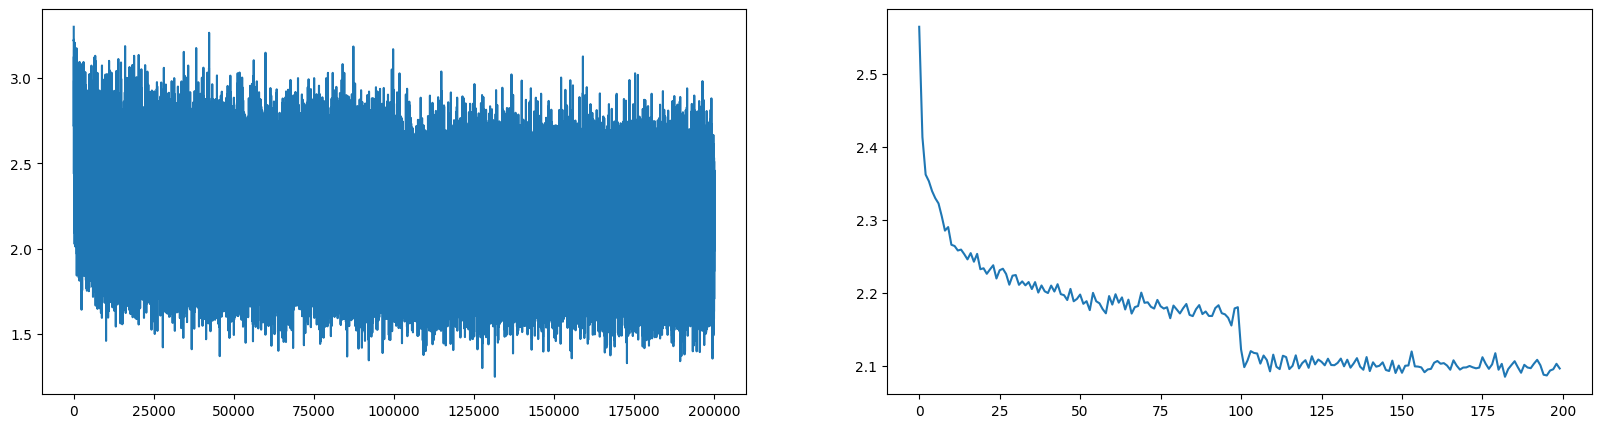

In [77]:
# original ctx len 3, hs 200
learn = LearnerBN(bl, gain=torch.nn.init.calculate_gain('tanh'))
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)
ax[0].plot(learn.iter, learn.losses) #row=0, col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) #row=0, col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
# learn.sample()

# Let's improve the code

In [78]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        ''' num_embeddings : number of classes for which to build the embs, n of rows '''
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self): return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1) # from [bs, ctx_len, emb_dim] to [bs, -1]
        return self.out

    def parameters(self): return []

    
class Sequential:
    def __init__(self, layers): self.layers = layers        
    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        self.out = x
        return self.out    
    def parameters(self): return [p for layer in self.layers for p in layer.parameters()]

In [83]:
class LearnerBN:
    def __init__(self, batch_loader, gain=torch.nn.init.calculate_gain('tanh'), lr=.1, ctx_len=ctx_len, emb_size=10, hidden_shape=200):
        self.batch_loader, self.lr, self.gain = batch_loader, lr, gain        
        self.ctx_len, self.emb_size, self.hidden_shape = ctx_len, emb_size, hidden_shape
        self.vocab_len = 27        
        self.model = self.init_model() 
        self.init_weights()

    def init_model(self):
        return Sequential([
            Embedding(self.vocab_len, self.emb_size),
            Flatten(),
            Linear(self.ctx_len*self.emb_size, self.hidden_shape, bias=False),
            BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.vocab_len)])

    def init_weights(self):
        with torch.no_grad():
            self.model.layers[-1].weight *= .1 # make last layer logits dist uniform
            for layer in self.model.layers: 
                if isinstance(layer, Linear): layer.weight *= self.gain        
        # self.parameters = self.model.parameters()            
        for p in self.model.parameters(): p.requires_grad = True

    def update_lr(self): self.lr = self.lr if self.i < 100000 else .01
    def plot_loss(self): plt.plot(self.iter, self.losses)
    def count_params(self): return sum(p.nelement() for p in self.model.parameters())
                
    def fit(self, steps):            
        for layer in self.model.layers: layer.training = True        
        self.losses, self.iter = [], []
        for self.i in range(steps+1):
            xb, yb = self.batch_loader()
            logits = self.model(xb)
            loss = F.cross_entropy(logits, yb)
            self.losses.append(loss.item()) 
            self.iter.append(self.i)
            for p in self.model.parameters(): p.grad = None
            loss.backward()
            self.update_lr()
            for p in self.model.parameters(): p.data += - self.lr * p.grad   
            if self.i % 50000 == 0: print(f'{self.i}/{steps} loss: {loss.item()}, lr: {self.lr}')
    
    @torch.no_grad()
    def evaluate_split_loss(self, xb, yb):
        for layer in self.model.layers: layer.training = False
        return F.cross_entropy(self.model(xb), yb)   
    
    def sample(self, nexamples=20):
        for layer in self.model.layers: layer.training = False
        # sample from the model
        for _ in range(nexamples):
            out = []
            context = [0] * ctx_len # initialize with all ...
            while True:
                probs = F.softmax(self.model(torch.tensor([context])), dim=1)  
                # sample from the distribution
                ix = torch.multinomial(probs, num_samples=1).item()
                # shift the context window and track the samples
                context = context[1:] + [ix]
                out.append(ix)
                # if we sample the special '.' token, break
                if ix == 0: break
            print(''.join(itos[i] for i in out)) # decode and print the generated word


# ALWAYS TRY TO AVOID TO MANTAIN STATE
# Wavenet: a hierarchical model
<img src="wavenet.gif" width="750" align="center">

Given that train loss and val loss are still quite close we still have margin to improve the model, but it is not
straight foward the "How to" improve it by increasing its size.

Now we want to use this wavenet architecture which just sequentially merges:
1) in the first layer characters (or words) 
2) in the second layer single representation of pair of chars/words obtained at layer 1
3) etc

So now first we increase the context lenght, s.t. use more of the representational power of this wavenet
Why we do this: we are crushing too much information in too fast in the hidden layer with the previous version of the nn.

In [84]:
ctx_len = 8
def build_dataset(words):
    global ctx_len
    ctx_len = 8
    X, Y = [], []    
    for w in words:
        # print('next word:', w)
        ctx = [0] * ctx_len
        for ch in w + '.':
            ix = stoi[ch] # get int version of next char, this is target
            X.append(ctx) # list of 3 ints, each char in ctx
            Y.append(ix) # next char as int
            # print(f"{''.join(list(map(lambda i: itos[i], ctx )))} ===> {itos[ix]}")
            ctx = ctx[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [85]:
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

xtrain, ytrain = build_dataset(words[:n1])
xvalid, yvalid = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

print(xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape, xtest.shape, ytest.shape)

bl = BatchLoader(xtrain, ytrain, 32)
for x,y in zip(xtrain[:20], ytrain[:20]): print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

torch.Size([182383, 8]) torch.Size([182383]) torch.Size([22907, 8]) torch.Size([22907]) torch.Size([22856, 8]) torch.Size([22856])
........ --> c
.......c --> r
......cr --> o
.....cro --> s
....cros --> b
...crosb --> y
..crosby --> .
........ --> n
.......n --> e
......ne --> h
.....neh --> e
....nehe --> m
...nehem --> i
..nehemi --> e
.nehemie --> .
........ --> r
.......r --> e
......re --> n
.....ren --> j
....renj --> i


Number of parameters: 22097
0/200000 loss: 3.3006908893585205, lr: 0.1
50000/200000 loss: 2.120755672454834, lr: 0.1
100000/200000 loss: 2.33341121673584, lr: 0.01
150000/200000 loss: 2.101567506790161, lr: 0.01
200000/200000 loss: 1.629352331161499, lr: 0.01
Loss on train: 1.9411323070526123
Loss on valid: 2.033561944961548


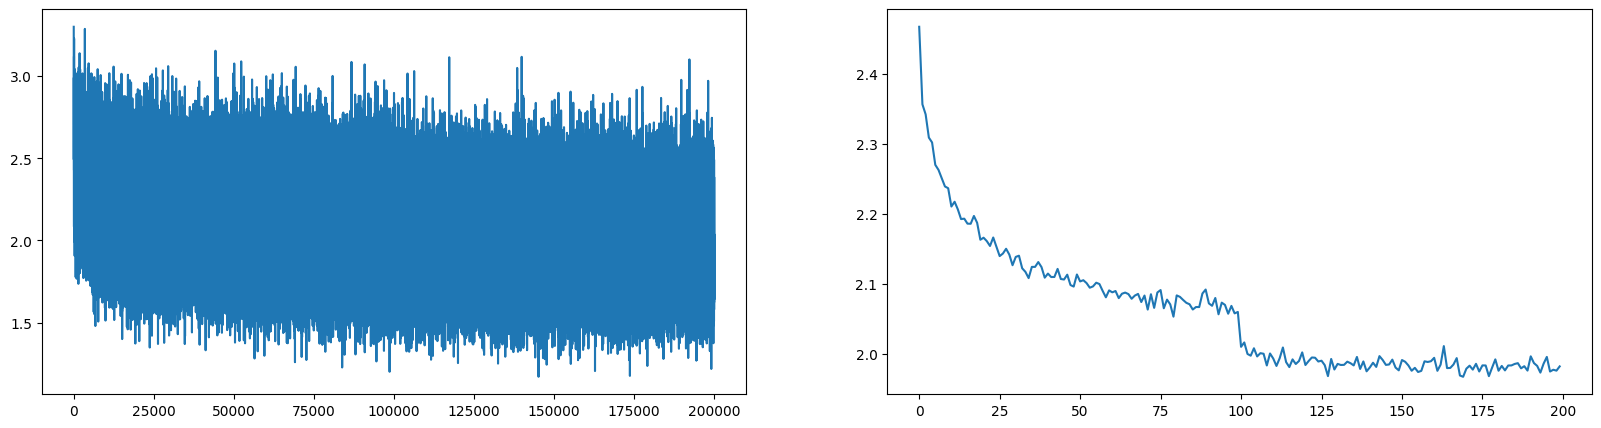

In [86]:
# original ctx 8, hs 200
learn = LearnerBN(bl)
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)
ax[0].plot(learn.iter, learn.losses) #row=0, col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) #row=0, col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
# learn.sample()

# Let's study input shapes to see how we can implement wavenet

In [87]:
ix = torch.randint(0, xtrain.shape[0], (4,))
xb = xtrain[ix]
print(xb.shape)
logits = learn.model(xb)
xb # inputs pre embeddings

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 18,  1, 22],
        [ 0,  0,  0,  0,  0, 12,  5, 14],
        [ 0,  0,  0,  0,  0, 14,  9,  3],
        [ 0,  0,  0,  0,  0,  0, 14,  9]])

In [88]:
print(learn.model.layers[0].out.shape) # output of embedding layer
# output of embedding layer, feed to the nn
# each char/each ij of the embedding table
print(learn.model.layers[1].out.shape) # output of Flatten layer
# concatenation of embeddings to crate an observation using only embeddings
print(learn.model.layers[2].out.shape) # output of first lin layer without bias, projection layer
print(learn.model.layers[3].out.shape) # output of BN layer
print(learn.model.layers[4].out.shape) # output of tanh
print(learn.model.layers[5].out.shape) # output of logits

torch.Size([4, 8, 10])
torch.Size([4, 80])
torch.Size([4, 200])
torch.Size([4, 200])
torch.Size([4, 200])
torch.Size([4, 27])


In [89]:
# let's see a cool property of matrix multiplication in pytorch
print((torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
print((torch.randn(4, 5, 10, 15, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# all the dimensions on the left are kept unchanged, and treated as batch dimensions, only the last dim is used to compute the multiplication
a = (torch.randn(4, 5, 10, 15, 5) @ torch.randn(5, 10) + torch.randn(10))
a[0, 0, 0, 0, :] == a[1, 0, 0, 0, :] # each layer of a is randn wrt to the others

torch.Size([4, 200])
torch.Size([4, 5, 10, 15, 200])


tensor([False, False, False, False, False, False, False, False, False, False])

In [90]:
# before we thus we had for a single obs a row as following:
# 1 2 3 4 5 6 7 8
# now we want:
# (1 2) (3 4) (5 6) (7 8)
# 1) flatten their embedding repr
# 2) multiply them with a W, add biass
# do this in parallel for all the 4 groups, achieving this by treating each group as another batch dim

# right shapes for this new task:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape
# thus we need to changed the flattening layer 

torch.Size([4, 4, 200])

In [91]:
# Cool thing in python
print(list(range(10))[::2]) # grab all evens
list(range(10))[1::2] # grab all odds

[0, 2, 4, 6, 8]


[1, 3, 5, 7, 9]

In [92]:
# can be used here to index into tensor as we want:
e = torch.rand(4,8,10)# output of embedding layer
print(e.shape)

explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim =2)
print(explicit.shape)

with_view = e.view(e.shape[0], -1, 20)
print(with_view.shape)

(explicit == with_view).all()

torch.Size([4, 8, 10])
torch.Size([4, 4, 20])
torch.Size([4, 4, 20])


tensor(True)

# FlattenConsecutive

In [93]:
class FlattenConsecutive:
    def __init__(self, num_consec_els):
        # if num_consec_els = 2
        # eg: from [1, 2, 3, 4, 5, 6, 7, 8]
        # to: [(1, 2), (3, 4), (5, 6), (7, 8)]
        self.num_consec_els = num_consec_els

    def __call__(self, x):
        B, T, C = x.shape # bs, cxt_len, emb_dim
        self.out = x.view(x.shape[0], -1, self.num_consec_els * C)  # -1 == T//n
        if self.out.shape[1] == 1: self.out = self.out.squeeze(1) # impo for the last layer
        return self.out
    
    def parameters(self): return []

In [94]:
f = FlattenConsecutive(8)
test = torch.rand((3, 8, 10)); test.shape
f(test).shape

torch.Size([3, 80])

In [95]:
# new learner with new flatten:
class ConsecutiveLearner(LearnerBN):
    def __init__(self, bl): super().__init__(bl)
    def init_model(self):
        return Sequential([
            Embedding(self.vocab_len, self.emb_size),
            FlattenConsecutive(self.ctx_len),
            Linear(self.ctx_len*self.emb_size, self.hidden_shape, bias=False),            
            BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.vocab_len)])    
    def count_params(self): return sum(p.nelement() for p in self.model.parameters())

Number of parameters: 22097
0/200000 loss: 3.3088223934173584, lr: 0.1
50000/200000 loss: 2.576997995376587, lr: 0.1
100000/200000 loss: 1.976638674736023, lr: 0.01
150000/200000 loss: 2.1310691833496094, lr: 0.01
200000/200000 loss: 1.7452985048294067, lr: 0.01
Loss on train: 1.9466190338134766
Loss on valid: 2.03359317779541


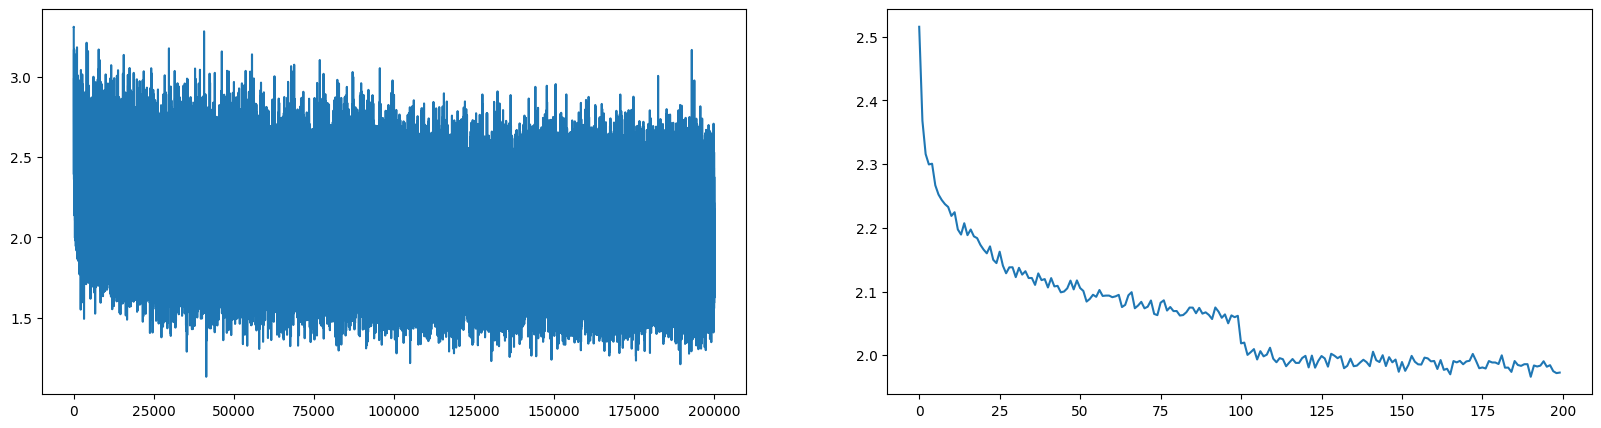

In [96]:
# original ctx 8, hs 200
learn = ConsecutiveLearner(bl)
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)
ax[0].plot(learn.iter, learn.losses) #row=0, col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) #row=0, col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
# learn.sample()

# WaveNet

In [105]:
# new learner with new flatten:
class ConsecutiveLearner(LearnerBN):
    def __init__(self, bl, emb_size=10, hidden_shape=200): super().__init__(bl, emb_size=emb_size, hidden_shape=hidden_shape)
    def init_model(self):
        return Sequential([
            Embedding(self.vocab_len, self.emb_size),
            # cat of 2 embedded chars
            # inp dims: self.emb_size=10, now we want cat of 2 embedded chars -> inp dim: self.emb_size*2   
            FlattenConsecutive(2), Linear(self.emb_size*2, self.hidden_shape, bias=False), BatchNorm1d(self.hidden_shape), Tanh(),
            # linear may take an arbitrary number of batch dims, but is always applied to the last dim
            FlattenConsecutive(2), Linear(self.hidden_shape*2, self.hidden_shape, bias=False), BatchNorm1d(self.hidden_shape), Tanh(),
            FlattenConsecutive(2), Linear(self.hidden_shape*2, self.hidden_shape, bias=False), BatchNorm1d(self.hidden_shape), Tanh(),
            Linear(self.hidden_shape, self.vocab_len)])    
    def print_outputs_shapes(self):
        for layer in self.model.layers: print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    def count_params(self): return sum(p.nelement() for p in self.model.parameters())


    # the idea here is that we obtain the forward step as shown in the gif by exploiting the batching mechanism of pytorch

In [98]:
# Embedding : (4, 8, 10)                     [1, 2, 3, 4, 5, 6, 7, 8]
# FlattenConsecutive : (4, 4, 20)            1 obs: [a=cat(1, 2), b=cat(3, 4), c=cat(5, 6), d=cat(7, 8)]
# Linear : (4, 4, 100)                       [a'=lin1(a), b'=lin1(b), c'=lin1(c), d'=lin1(d)]
# BatchNorm1d : (4, 4, 100)                  [a'=bn(lin1(a)), b'=bn(lin1(b)), c'=bn(lin1(c)), d'=bn(lin1(d))]
# Tanh : (4, 4, 100)                         [a'=tanh(bn(lin1(a))), b'=tanh(bn(lin1(b))), c'=tanh(bn(lin1(c))), d'=tanh(bn(lin1(d)))]

# FlattenConsecutive : (4, 2, 200)           [cat(a', b'), cat(c', d')] # reshaping of the previous output s.t. cat info from different chars (hierarchical)
# Linear : (4, 2, 100)
# BatchNorm1d : (4, 2, 100)                  feed thru second layer to get (ab)'' and (cd)''
# Tanh : (4, 2, 100)

# FlattenConsecutive : (4, 200)              [cat((ab)'', (cd)'')] 
# Linear : (4, 100)
# BatchNorm1d : (4, 100)
# Tanh : (4, 100)                            [global view of input in a single vector]
# Linear : (4, 27)                            sent to output space

In [99]:
learnTest = ConsecutiveLearner(bl, hidden_shape=68)
learnTest.fit(1)
learnTest.print_outputs_shapes()
print("Number of parameters:", learnTest.count_params())

0/1 loss: 3.2621302604675293, lr: 0.1
Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)
Number of parameters: 22397


Number of parameters: 22397
0/200000 loss: 3.275911331176758, lr: 0.1
50000/200000 loss: 1.9150992631912231, lr: 0.1
100000/200000 loss: 2.175767421722412, lr: 0.01
150000/200000 loss: 2.0419273376464844, lr: 0.01
200000/200000 loss: 1.8078596591949463, lr: 0.01
Loss on train: 1.9570211172103882
Loss on valid: 2.031986951828003


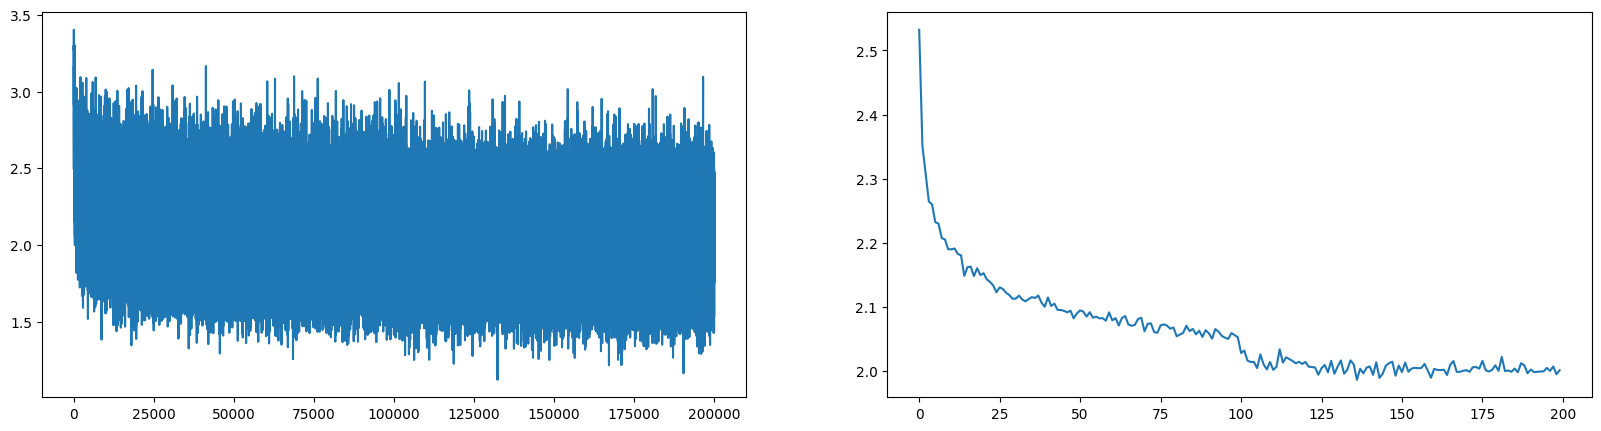

In [100]:
# again train baseline with 8 context lenght but with new flatten layer
learn = ConsecutiveLearner(bl,  hidden_shape=68)
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)

ax[0].plot(learn.iter, learn.losses) #row=0, col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) #row=0, col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
# learn.sample()

# Performance report:
- original, ctx len 3, hs 200
    - Number of parameters: 12567
    - Loss on train: 2.067540407180786
    - Loss on valid: 2.112969398498535

- original, ctx len 8, hs 200, refactored code
    - Number of parameters: 22097
    - Loss on train: 1.9411323070526123
    - Loss on valid: 2.033561944961548

- original, ctx len 8, hs 200, refactored code
    - Number of parameters: 22097
    - Loss on train: 1.9466190338134766
    - Loss on valid: 2.03359317779541

- wavenet, ctx len 8, hs 68 with BN bug!
Number of parameters: 22397
    - 0/200000 loss: 3.275911331176758, lr: 0.1
    - Loss on train: 1.9570211172103882
    - Loss on valid: 2.031986951828003

Mantaining the number of parameters fixed, with the hierarchical model we didnt gain at all wrt the original implementation!

- wavenet, ctx len 8, hs 68 WITHOUT BN bug!
    - Number of parameters: 22397
    - Loss on train: 1.932480812072754
    - Loss on valid: 2.0240392684936523

No major changes, only slight improvement

- wavenet, ctx len 8, hs 128, emb size 24, fixed bn
    - Number of parameters: 76579
    - Loss on train: 1.791242003440857
    - Loss on valid: 1.9955121278762817

yay!

In [102]:
# original bn takes mean over 0 dim (i.e. batch dim, but not on any other dim )
# we are mantaining statistics for batch and each position in the second dim
# what we actually want is the mean and var over all things in the last dim which is the actual data

class BatchNorm1d:    
    def __init__(self, dims, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # bn params
        self.gamma = torch.ones(dims)
        self.beta = torch.zeros(dims)
        # buffers
        self.running_mean = torch.zeros(dims)
        self.running_var = torch.ones(dims)
        
        
    def __call__(self, x):
        if self.training: # use batch stats
            if x.ndim == 2: dim = 0
            elif x.ndim == 3: dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else: # use running stats
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self): return [self.gamma, self.beta]

Number of parameters: 22397
0/200000 loss: 3.306278944015503, lr: 0.1
50000/200000 loss: 2.0953354835510254, lr: 0.1
100000/200000 loss: 1.652317762374878, lr: 0.01
150000/200000 loss: 2.045888662338257, lr: 0.01
200000/200000 loss: 2.061155319213867, lr: 0.01
Loss on train: 1.932480812072754
Loss on valid: 2.0240392684936523


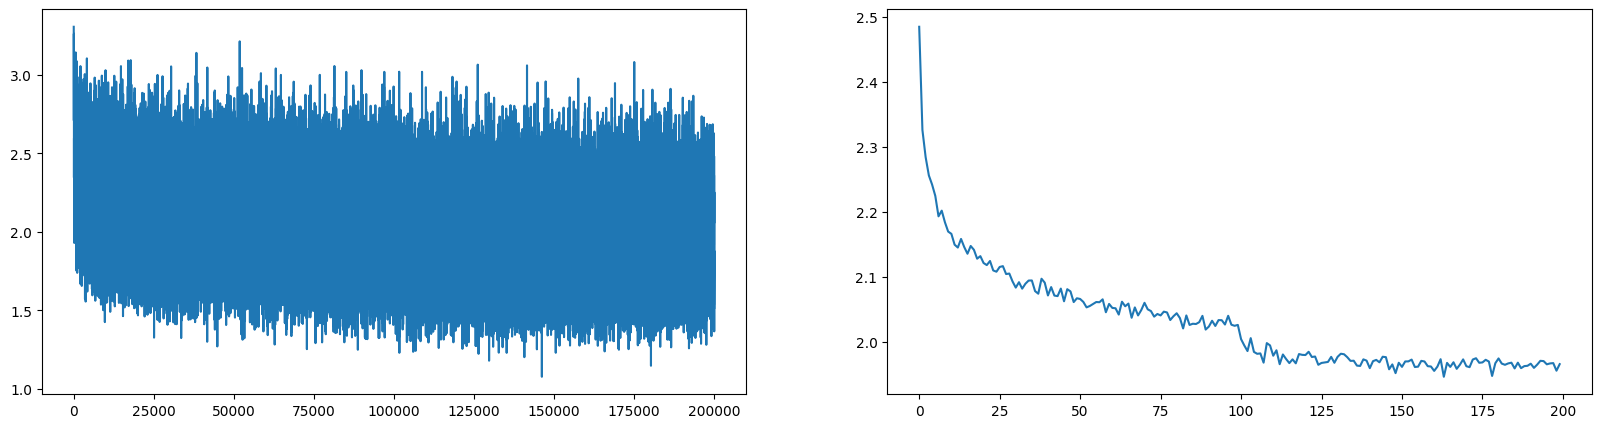

In [103]:
# retrain after fixing bn bug
learn = ConsecutiveLearner(bl,  hidden_shape=68)
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)

ax[0].plot(learn.iter, learn.losses) #row=0, col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) #row=0, col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
# learn.sample()

Number of parameters: 76579
0/200000 loss: 3.293203353881836, lr: 0.1
50000/200000 loss: 2.4710357189178467, lr: 0.1
100000/200000 loss: 1.9877591133117676, lr: 0.01
150000/200000 loss: 1.9617522954940796, lr: 0.01
200000/200000 loss: 2.1781396865844727, lr: 0.01
Loss on train: 1.791242003440857
Loss on valid: 1.9955121278762817
karmichael.
ellino.
domar.
alexina.
anayka.
anji.
saraan.
jessel.
oakleigh.
starlito.
lorell.
jiah.
basey.
beylor.
ellaise.
maleyn.
shep.
brelion.
shaylah.
zayla.


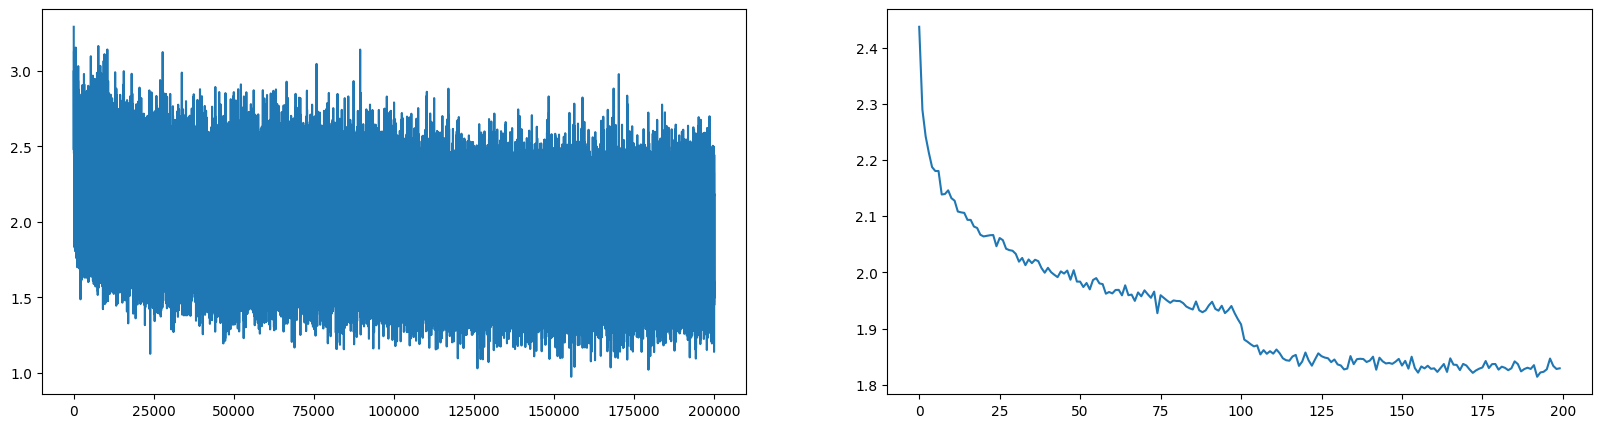

In [106]:
# retrain after fixing bn bug
learn = ConsecutiveLearner(bl, emb_size=24, hidden_shape=128)
print("Number of parameters:", learn.count_params())
learn.fit(max_steps)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20, 5)

ax[0].plot(learn.iter, learn.losses) # col=0
ax[1].plot(torch.tensor(learn.losses[:-1]).view(-1, 1000).mean(1)) # col=1

print(f'Loss on train: {learn.evaluate_split_loss(xtrain, ytrain)}')
print(f'Loss on valid: {learn.evaluate_split_loss(xvalid, yvalid)}')   
learn.sample()